In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import PIL

from keras.utils import np_utils                          # tools for creating one-hot encoding
from keras.models import Sequential                       # Type of model we wish to use
from keras.layers.core import Dense, Dropout, Activation  # Types of layers we wish to use

from skimage.transform import resize                      # Used to scale/resize image arrays

from sklearn.metrics import confusion_matrix              # Used to quickly make confusion matrix
     

In [8]:
### Settings

# Location of dataset
DATASET_PATH = "./dataset"

# Desired resolution of images
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# Invert image (dark backgrounds can sometimes improve accuracy)
INVERT = False

# Set aside 20% for validation and 20% for test
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# You are welcome to change the seed to try a different validation set split
random.seed(42)

In [9]:
### Load images as Numpy arrays

# We want to record the labels and assign a ground truth label as a number to each sample
labels = []
y_all = []    # Lowercase 'y' - 1D vector of the ground labels (n)
X_all = []    # Uppercase 'X' - 3D array of all image samples (n x width x height)

# Find the directories in the dataset folder (skip the Jupyter Notebook checkpoints hidden folder)
for label in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, label)
    if os.path.isdir(class_dir) and label != ".ipynb_checkpoints":

    # Add the name of the folder to our labels list
        labels.append(label)

    # Go through each image in the folder
        for i, file in enumerate(os.listdir(class_dir)):

      # Skip the Jupyter Notebook checkpoints folder that sometimes gets added
            if file != ".ipynb_checkpoints":

        # Open image and convert to grayscale
                file_path = os.path.join(class_dir, file)
                img = PIL.Image.open(file_path).convert('L')

        # Convert the image to a Numpy array, optionally invert, and append to X
                img_array = np.asarray(img)
                if INVERT:
                    img_array = 255 - img_array
                X_all.append(img_array)

        # Add label to the y array
                y_all.append(label)

    # Show how many images we loaded
    print("Added", str(i + 1), "images from", label)

# Calculate total number of samples
num_samples = len(X_all)

# Sort the labels list by alphabetical order
labels = sorted(labels)

# Print out labels and number of samples
print(labels)
print("Number of samples:", num_samples)

Added 50 images from background
Added 50 images from capacitor
Added 50 images from diode
Added 50 images from led
Added 50 images from resistor
['background', 'capacitor', 'diode', 'led', 'resistor']
Number of samples: 250


In [10]:
### Convert labels to numbers

# Show the labels before the conversion
print("Before:", y_all)

# Convert each label to its index in the labels
y_out = []
for i, label in enumerate(y_all):
    y_out.append(labels.index(label))
y_all = y_out

# Show the labels after the conversion
print("After:", y_all)

Before: ['background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capa

In [11]:
### Shuffle samples and labels together, divide into test, validation, and training sets

# Shuffle samples and associated labels together
X_y = list(zip(X_all, y_all))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)
num_samples_val = int(VAL_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The next `num_samples_val` samples of the shuffled list becomes the validation set
X_val = X_all[num_samples_test:(num_samples_test + num_samples_val)]
y_val = y_all[num_samples_test:(num_samples_test + num_samples_val)]

# The remaining samples become the training set
X_train = X_all[(num_samples_test + num_samples_val):]
y_train = y_all[(num_samples_test + num_samples_val):]

# Remember the number of samples in the test set
num_samples_train = len(X_train)

# Print out the number of test, validation, and training samples
print("Number of test samples:", num_samples_test)
print("Number of validation samples:", num_samples_val)
print("Number of training samples:", num_samples_train)

Number of test samples: 50
Number of validation samples: 50
Number of training samples: 150


Label: 2 (diode)
[[147 147 149 ... 149 149 149]
 [147 147 149 ... 149 149 149]
 [147 147 149 ... 149 149 149]
 ...
 [139 139 139 ... 155 155 155]
 [139 139 139 ... 149 155 155]
 [139 139 139 ... 149 149 155]]


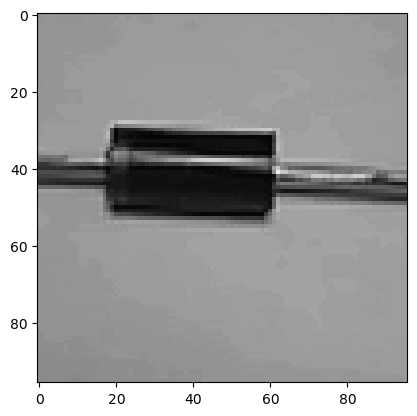

In [12]:
### View one of the training samples

# Chose which sample you want to view
idx = 0

# Print out label (numbe and string) and part of the array
print("Label: " + str(y_train[idx]) + " (" + labels[y_train[idx]] + ")")
print(X_train[idx])

# Display image from array
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)

In [13]:
### Function to resize list of images
def resize_images(images, width, height, anti_aliasing=True):
    """
        Prove a list of Numpy arrays (in images parameter) to have them all resized to desired height and
        width. Returns the list of newly resized image arrays.
        NOTE: skimage resize returns *normalized* image arrays (values between 0..1)
    """
    X_out = []
    for i, img in enumerate(images):
        X_out.append(resize(img, (height, width), anti_aliasing=anti_aliasing))
    return X_out

In [14]:
### Scale/crop images

# Resize (scale) all images in the training set
X_train = resize_images(X_train, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the validation set
X_val = resize_images(X_val, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the test set
X_test = resize_images(X_test, TARGET_WIDTH, TARGET_HEIGHT)

Label: 4 (resistor)
First row: [[0.6079352  0.60865204 0.60789576 0.61024736 0.6131318  0.61409879
  0.61423407 0.61561215 0.61789371 0.61927392 0.61754428 0.6166201
  0.63398467 0.63920811 0.63921571 0.63922443 0.63945846 0.63924647
  0.63949504 0.6396273  0.63941302 0.63922086 0.63921569 0.63921569
  0.63920173 0.63905615 0.6373652  0.63206179]]


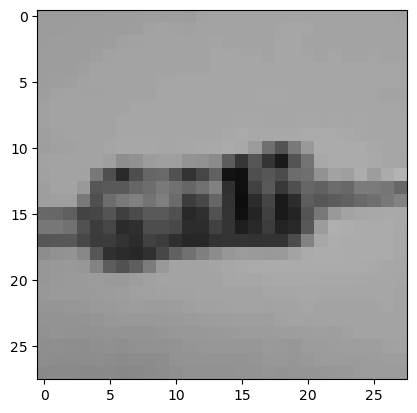

In [23]:
### View training sample again (after they all have been scaled)

# Chose which sample you want to view
idx = 10

# Print out label (numbe and string) and part of the array
print("Label: " + str(y_train[idx]) + " (" + labels[y_train[idx]] + ")")
print("First row:", X_train[idx][:1,:])

# Display image from array (note that images have been normalized)
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=1)
     